# Fart Data Extraction Protocol

In this colab we extract five publicly accessible databases:


*   FlavorDB
*   ChemTastesDB
*   IUPAC pkA database
*   PhytocompoundsDB
*   Tas2R Agonists
*   Umami compounds from Ref. [1]

[1] B. Suess, D. Festring, T. Hofmann. Umami compounds and taste enhancers, In Woodhead Publishing Series in Food Science, Technology and Nutrition, Flavour Development, Analysis and Perception in Food and Beverages,Woodhead Publishing, 2015, p. 331-351.



In [60]:
!pip install rdkit

In [64]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=abfc3f239ebef7580c7bd5bb4f3300172b54b8582e45326d1c890e3525335b10
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [68]:
import pandas as pd
import numpy as np
from collections import Counter
from rdkit import Chem
import requests
from bs4 import BeautifulSoup
import pubchempy as pcp
from tqdm import tqdm


The final database is saved in 'fart_uncurated.csv' with columns


*   Canonicalized SMILES
*   Canonicalized Flavor
*   Source

Here we initialize the empty pandas dataframe for use later.

In [355]:
columns = ['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']
fart_uncurated = pd.DataFrame(columns=columns)

# arrays for the final plot
full_dataset_size = [0]  # collects the size of dataset at each stage
dataset_stage = ['initialization']

## Utils

In [185]:
# Helper function
# Split the flavors from a string 'flavor1, flavor2, ...' into a list of flavors
def split_flavors(flavor_string):
    # Ensure the input is a string
    str(flavor_string)
    # Check if the input is indeed a string
    if isinstance(flavor_string, str):
        # Split the string by ', ' to create a list of flavors
        return flavor_string.split(', ')
    else:
        # Print an error message if the input is not a string
        print('ERROR, flavor_string is not a string', flavor_string)
        return []

# Input: data frame, name for the flavor/taste column of interest
# Transform the row 'flavor_column_name' so that instead of one string value it
# contains the list of all strings
def flavors_to_list(data, flavor_column_name='Flavor'):
    # Apply the split_flavors function to each entry in the specified column
    data[flavor_column_name] = data[flavor_column_name].apply(lambda x: split_flavors(x))
    return data

# Input: data frame, name for the flavor/taste column of interest
# Output: dictionary {'flavor': number_of_occurrences}
def distinct_flavors(data, flavor_column_name="Flavor"):
    # Convert the flavors to a list format
    data = flavors_to_list(data.copy(), flavor_column_name)

    # Flatten the list of lists into a single list of all flavors
    all_flavors = [flavor for sublist in data[flavor_column_name] for flavor in sublist]

    # Count the occurrences of each flavor
    taste_counts = Counter(all_flavors)

    # Convert the Counter object to a dictionary and sort by occurrence count
    taste_counts_dict = dict(taste_counts)
    taste_counts_dict = dict(sorted(taste_counts_dict.items(), key=lambda item: item[1], reverse=True))

    return taste_counts_dict

# Function to tidy the canonical flavors
def tidy_canonical_flavors(df):
    new_rows = []
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the 'Canonicalized Taste Intermediary' column is a list
        if isinstance(row['Canonicalized Taste Intermediary'], list):
            flavors = row['Canonicalized Taste Intermediary']
            # Create a new row for each flavor in the list
            for flavor in flavors:
                new_row = row.copy()
                new_row['Canonicalized Taste Intermediary'] = flavor
                new_row['Canonicalized Taste'] = str(flavor)
                new_rows.append(new_row)
        else:
            # If it's not a list, just convert the value to string and add the row
            row['Canonicalized Taste'] = str(row['Canonicalized Taste Intermediary'])
            new_rows.append(row)
    return pd.DataFrame(new_rows)

# Function to canonicalize SMILES strings
def canonicalize_smiles(smiles):
    # Convert SMILES string to a molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Convert molecule object back to a canonical SMILES string
        return Chem.MolToSmiles(mol)
    else:
        # Return None if the SMILES string is invalid
        return None

# Function to canonicalize SMILES strings in a DataFrame column
def canonicalize_smiles_column(df, smiles_name='SMILES'):
    # Drop rows where the SMILES column is NaN
    df = df.dropna(subset=[smiles_name])
    # Apply the canonicalize_smiles function to the SMILES column
    df['Canonicalized SMILES'] = df[smiles_name].apply(canonicalize_smiles)
    return df


## ChemtastesDB

ChemtastesDB is accessible as an excel document online

In [308]:
chemtastes_db = pd.read_excel("https://zenodo.org/records/5747393/files/ChemTastesDB_database.xlsx?download=1")
chemtastes_db = chemtastes_db.dropna(subset=["Class taste"])

We care about the column "Class Taste" mostly as this already maps relatively well to our own canonical categories. The case of "multitaste" is treated separately and gets mapped onto one of the canonical tastes where possible. Else it is labeled as "undefined".

In [309]:
FLAVOR_CATEGORIES_map_chemtastes = {
    'Sweetness' : 'sweet',
    'Bitterness': 'bitter',
    'Umaminess' : 'umami',
    'Sourness': 'sour'
}

FLAVOR_CATEGORIES_map_chemtastes_multiflavors = {
    'Acid' : 'sour',
    'Bitter' : 'bitter',
    'Moderately bitter' : 'bitter',
    'Sour' : 'sour',
    'Sweet' : 'sweet',
    'Umami' : 'umami'
}

def map_flavor(row):
    class_taste = row["Class taste"]
    if class_taste == "Multitaste":
        return 'multi'
    else:
        return [FLAVOR_CATEGORIES_map_chemtastes.get(class_taste, 'undefined')]

chemtastes_db['Canonicalized Taste Intermediary'] = chemtastes_db.apply(map_flavor, axis=1)

This code handles the case of multitaste where the additional column "Taste" is considered. The mapping happens in accordance to the code above.

In [310]:
import re

def split_flavors(text):
    split_list = re.split(r'[;,/]', text)
    return [word.strip() for word in split_list if word.strip()]

chemtastes_db.loc[chemtastes_db["Class taste"].apply(lambda x: x[0] == "Multitaste"), "Taste"] = chemtastes_db.loc[chemtastes_db["Class taste"].apply(lambda x: x[0] == "Multitaste"), "Taste"].apply(split_flavors)

multitastes = chemtastes_db[chemtastes_db["Class taste"].apply(lambda x: x[0] == "Multitaste")]

def translate_flavors(item_list):
    return [FLAVOR_CATEGORIES_map_chemtastes_multiflavors.get(item, 'undefined') for item in item_list]

for idx, row in chemtastes_db[chemtastes_db['Canonicalized Taste Intermediary'] == 'multi'].iterrows():
    chemtastes_db.at[idx, "Canonicalized Taste Intermediary"] = translate_flavors(row["Taste"])


The list of tastes is then flattened and made fully canonical.

In [311]:
chemtastes_db = tidy_canonical_flavors(chemtastes_db)
print(distinct_flavors(chemtastes_db, "Canonicalized Taste"))

{'undefined': 2090, 'bitter': 1183, 'sweet': 977, 'umami': 98, 'sour': 38}


Canonicalize the SMILES and give the source and original labels. Both class taste and taste are considered original labels in this case.  

In [312]:
chemtastes_db = canonicalize_smiles_column(chemtastes_db, 'canonical SMILES')
chemtastes_db['Source'] = 'ChemTastesDB'
chemtastes_db['Original Labels'] = chemtastes_db['Taste'] + ', ' + chemtastes_db['Class taste']

In [313]:
# save this database as an intermediate csv file
chemtastes_db.to_csv('chemtastes_db.csv', index=False)

Concatenate ChemTastesDB to the final dataframe.

In [356]:
chemtastes_db_subset = chemtastes_db[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
chemtastes_db_subset = chemtastes_db_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, chemtastes_db_subset], axis=0, ignore_index=True)

In [357]:
# updates lists for final plot
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('ChemtastesDB')
len(fart_uncurated)

4386

## Flavor DB

Here we extract the data from flavordb via web scraping. The database contains a "Taste" column which is unreliable however and mostly empty. We therefore focus on the "Flavor Profile" which contains a mixture of fragrance and taste cues. In our relabelling scheme we try to only include adjectives which are clearly taste associated.

In [194]:
base_url = "https://cosylab.iiitd.edu.in/flavordb/molecules?advance_search=true&num_rings=0%3A10&page="

molecules = []

for page in range(1, 513):
    url = f"{base_url}{page}"
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        for row in soup.select("table#molecules tbody tr"):
            cols = row.find_all("td")
            if len(cols) >= 2:
                name = cols[0].text.strip()
                pubchem_id = cols[1].text.strip()
                flavor = cols[2].text.strip()
                molecules.append((name, pubchem_id, flavor))
    else:
        print(f"Failed to retrieve page {page}")

    print(f"Processed page {page}/{512}")

print(f"Total molecules scraped: {len(molecules)}")

import pandas as pd

df = pd.DataFrame(molecules, columns=['Name', 'PubChem ID', 'Flavor'])
df.to_csv('flavor_db_raw.csv', index=False)
print("Data saved to flavor_db_raw.csv")

Processed page 1/512
Processed page 2/512
Processed page 3/512
Processed page 4/512
Processed page 5/512
Processed page 6/512
Processed page 7/512
Processed page 8/512
Processed page 9/512
Processed page 10/512
Processed page 11/512
Processed page 12/512
Processed page 13/512
Processed page 14/512
Processed page 15/512
Processed page 16/512
Processed page 17/512
Processed page 18/512
Processed page 19/512
Processed page 20/512
Processed page 21/512
Processed page 22/512
Processed page 23/512
Processed page 24/512
Processed page 25/512
Processed page 26/512
Processed page 27/512
Processed page 28/512
Processed page 29/512
Processed page 30/512
Processed page 31/512
Processed page 32/512
Processed page 33/512
Processed page 34/512
Processed page 35/512
Processed page 36/512
Processed page 37/512
Processed page 38/512
Processed page 39/512
Processed page 40/512
Processed page 41/512
Processed page 42/512
Processed page 43/512
Processed page 44/512
Processed page 45/512
Processed page 46/5

Now we enrich the database to also contain a SMILES columns instead of just the names of molecules.

In [198]:
def get_name_smiles(pubchem_id):
    try:
        compound = pcp.Compound.from_cid(pubchem_id)
        return compound.canonical_smiles, compound.iupac_name
    except Exception as e:
        print(f"Error fetching data for CID {pubchem_id}: {e}")
        return None, None


def process_batch(batch):
    """Process a batch of PubChem IDs."""
    tqdm.pandas()
    batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
    batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
    batch.drop(columns=['SMILES_IUPAC'], inplace=True)
    return batch


# Load the original dataset
df_original = pd.read_csv('flavor_db_raw.csv')  # Path to your full dataset

# Try to load the partially processed dataset; if not found, start with an empty DataFrame
try:
    df_processed = pd.read_csv('flavor_db_scraped.csv')  # current progress
    print("Loaded partially processed data.")
except FileNotFoundError:
    df_processed = pd.DataFrame(columns=df_original.columns.tolist() + ['SMILES', 'IUPAC Name'])
    print("Starting from scratch.")

processed_ids = set(df_processed['PubChem ID'])
df_unprocessed = df_original[~df_original['PubChem ID'].isin(processed_ids)]

# Batch processing settings
batch_size = 500
num_batches = len(df_unprocessed) // batch_size + (0 if len(df_unprocessed) % batch_size == 0 else 1)

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = min((i + 1) * batch_size, len(df_unprocessed))
    print(f"Processing batch {i + 1}/{num_batches}: IDs {batch_start} to {batch_end}")

    batch = df_unprocessed.iloc[batch_start:batch_end]
    processed_batch = process_batch(batch)

    df_processed = pd.concat([df_processed, processed_batch], ignore_index=True)

df_processed.to_csv('flavor_db_scraped.csv', index=False)

print("Data processing complete. All data saved.")
flavor_db = df

Starting from scratch.
Processing batch 1/52: IDs 0 to 500


100%|██████████| 500/500 [02:34<00:00,  3.25it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 2/52: IDs 500 to 1000


100%|██████████| 500/500 [02:32<00:00,  3.29it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 3/52: IDs 1000 to 1500


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 4/52: IDs 1500 to 2000


100%|██████████| 500/500 [02:36<00:00,  3.20it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 5/52: IDs 2000 to 2500


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 6/52: IDs 2500 to 3000


100%|██████████| 500/500 [02:48<00:00,  2.97it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 7/52: IDs 3000 to 3500


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 8/52: IDs 3500 to 4000


100%|██████████| 500/500 [02:52<00:00,  2.91it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 9/52: IDs 4000 to 4500


100%|██████████| 500/500 [02:56<00:00,  2.83it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 10/52: IDs 4500 to 5000


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 11/52: IDs 5000 to 5500


100%|██████████| 500/500 [02:48<00:00,  2.97it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 12/52: IDs 5500 to 6000


100%|██████████| 500/500 [02:57<00:00,  2.82it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 13/52: IDs 6000 to 6500


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 14/52: IDs 6500 to 7000


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 15/52: IDs 7000 to 7500


100%|██████████| 500/500 [02:54<00:00,  2.86it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 16/52: IDs 7500 to 8000


100%|██████████| 500/500 [02:51<00:00,  2.92it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 17/52: IDs 8000 to 8500


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 18/52: IDs 8500 to 9000


100%|██████████| 500/500 [02:53<00:00,  2.87it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 19/52: IDs 9000 to 9500


100%|██████████| 500/500 [02:53<00:00,  2.88it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 20/52: IDs 9500 to 10000


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 21/52: IDs 10000 to 10500


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 22/52: IDs 10500 to 11000


100%|██████████| 500/500 [02:52<00:00,  2.89it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 23/52: IDs 11000 to 11500


100%|██████████| 500/500 [02:53<00:00,  2.88it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 24/52: IDs 11500 to 12000


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 25/52: IDs 12000 to 12500


100%|██████████| 500/500 [02:54<00:00,  2.87it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 26/52: IDs 12500 to 13000


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 27/52: IDs 13000 to 13500


100%|██████████| 500/500 [02:56<00:00,  2.84it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 28/52: IDs 13500 to 14000


100%|██████████| 500/500 [02:55<00:00,  2.84it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 29/52: IDs 14000 to 14500


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 30/52: IDs 14500 to 15000


100%|██████████| 500/500 [02:56<00:00,  2.84it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 31/52: IDs 15000 to 15500


100%|██████████| 500/500 [02:56<00:00,  2.84it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 32/52: IDs 15500 to 16000


100%|██████████| 500/500 [02:54<00:00,  2.86it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 33/52: IDs 16000 to 16500


100%|██████████| 500/500 [02:57<00:00,  2.82it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 34/52: IDs 16500 to 17000


100%|██████████| 500/500 [02:55<00:00,  2.86it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 35/52: IDs 17000 to 17500


100%|██████████| 500/500 [02:54<00:00,  2.86it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 36/52: IDs 17500 to 18000


100%|██████████| 500/500 [02:56<00:00,  2.83it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 37/52: IDs 18000 to 18500


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 38/52: IDs 18500 to 19000


100%|██████████| 500/500 [02:56<00:00,  2.83it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 39/52: IDs 19000 to 19500


100%|██████████| 500/500 [02:57<00:00,  2.82it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 40/52: IDs 19500 to 20000


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 41/52: IDs 20000 to 20500


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 42/52: IDs 20500 to 21000


100%|██████████| 500/500 [02:53<00:00,  2.88it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 43/52: IDs 21000 to 21500


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 44/52: IDs 21500 to 22000


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 45/52: IDs 22000 to 22500


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 46/52: IDs 22500 to 23000


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 47/52: IDs 23000 to 23500


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 48/52: IDs 23500 to 24000


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 49/52: IDs 24000 to 24500


100%|██████████| 500/500 [02:59<00:00,  2.79it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 50/52: IDs 24500 to 25000


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 51/52: IDs 25000 to 25500


100%|██████████| 500/500 [02:58<00:00,  2.81it/s]
<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Processing batch 52/52: IDs 25500 to 25559


100%|██████████| 59/59 [00:22<00:00,  2.67it/s]

Data processing complete. All data saved.



<ipython-input-198-44630f5fcce5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES_IUPAC'] = batch['PubChem ID'].progress_apply(lambda x: get_name_smiles(x))
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['SMILES'], batch['IUPAC Name'] = zip(*batch['SMILES_IUPAC'])
<ipython-input-198-44630f5fcce5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [331]:
# read in the data from the saved intermediary csv file
flavor_db = pd.read_csv('flavor_db_scraped.csv')
flavor_db = flavor_db.dropna(subset=['Flavor'])

This list gives an overview of what labels exists and how common they are.

In [332]:
flavor_db_distinct_flavors = distinct_flavors(flavor_db, 'Flavor')
print(flavor_db_distinct_flavors)

{'sweet-like': 13754, 'sweet': 8804, 'bitter': 738, 'fruity': 640, 'green': 540, 'floral': 309, 'woody': 243, 'herbal': 221, 'waxy': 211, 'fatty': 191, 'odorless': 162, 'spicy': 159, 'fresh': 158, 'nutty': 143, 'citrus': 138, 'earthy': 127, 'rose': 120, 'balsam': 117, 'sulfurous': 115, 'roasted': 115, 'oily': 112, 'tropical': 108, 'meaty': 103, 'apple': 100, 'pineapple': 97, 'musty': 96, 'vegetable': 90, 'fruit': 88, 'creamy': 86, 'minty': 78, 'mild': 77, 'phenolic': 76, 'caramel': 74, 'onion': 74, 'spice': 72, 'pungent': 70, 'berry': 69, 'powdery': 69, 'honey': 64, 'garlic': 59, 'ethereal': 58, 'vanilla': 57, 'coconut': 56, 'pear': 56, 'camphor': 55, 'banana': 55, 'almond': 49, 'dry': 49, 'sulfury': 48, 'mushroom': 47, 'peach': 47, 'coffee': 47, 'orange': 46, 'melon': 46, 'cherry': 45, 'cheese': 45, 'burnt': 45, 'metallic': 45, 'herb': 44, 'wood': 43, 'aldehydic': 41, 'cocoa': 41, 'flower': 40, 'fat': 40, 'wine': 40, 'apricot': 39, 'fishy': 38, 'chocolate': 37, 'cooked': 37, 'jasmin':

We now need to relabel the taste. We opted for an approach where we try to avoid labelling fragrance molecules with a taste as it is generally not true that taste and smell are equivalent. Hence, only very obviously attributable adjectives (e.g. "sweet-like") where also considered for the relabeling. Note that this will still label molecules whose "Flavor Profile" may be based on fragrance alone as a tasting molecule. Hence a sweet-smelling molecule might still be labeled as a sweet-tasting molecule.

In [333]:
def canonicalize_flavors(flavor_list):
    assigned_flavors = []
    if ('sweet' in flavor_list) or ('sweet-like' in flavor_list):
      assigned_flavors.append('sweet')
    if ('bitter' in flavor_list):
      assigned_flavors.append('bitter')
    if ('sour' in flavor_list) or ('acid' in flavor_list):
      assigned_flavors.append('sour')
    if len(assigned_flavors) == 0:
      assigned_flavors.append('undefined')
    assigned_flavors_string = ', '.join(assigned_flavors)
    return assigned_flavors

flavor_db['Canonicalized Taste Intermediary'] = flavor_db['Flavor'].apply(lambda x: canonicalize_flavors(x))

Here we add the remaining columns. In this case original labels corresponds to the "Flavor Profile" given by FlavorDB here given in the column "Flavor".

In [334]:
# flatten and canonicalized list of tastes
flavor_db = tidy_canonical_flavors(flavor_db)
# canonicalize SMILES
flavor_db = canonicalize_smiles_column(flavor_db)
# list source
flavor_db['Source'] = 'flavor_db'
# list original labels
flavor_db['Original Labels']  = flavor_db['Flavor']

[21:00:30] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:31] WARNING: not removing hydrogen atom without neighbors
[21:00:34] WARNING: not removing hydrogen atom without neighbors
[21:00:34] WARNING: not removing hydrogen atom without neighbors
[21:00:34] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not removing hydrogen atom without neighbors
[21:00:35] WARNING: not r

In [335]:
# save database as an intermediate csv file
flavor_db.to_csv('flavor_db.csv', index=False)

Concatenate FlavorDB to the final dataframe

In [358]:
flavor_db_subset = flavor_db[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
flavor_db_subset = flavor_db_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, flavor_db_subset], axis=0, ignore_index=True)

In [359]:
# update lists for plot at the end
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('FlavorDB')
len(fart_uncurated)

29523

## Tas2R Agonists

The Tas2R Agonists DB is available as an excel sheet from a github repository.

In [212]:
TAS2R_agonists = pd.read_excel("https://github.com/dipizio/Natural_TAS2R_agonists/raw/main/Database%20of%20natural%20TAS2R%20agonists.xlsx", skiprows=1)

# only extract these columns
tas2r_agonists = TAS2R_agonists[['Names', 'Canonical SMILES', 'INCHIKEY', 'CAS number']]

# add remaining columns
tas2r_agonists['Canonicalized Taste'] = 'bitter'
tas2r_agonists['Source'] = 'tas2r_agonists'
tas2r_agonists['Original Labels'] = 'Ligand to Tas2 Receptor'

<ipython-input-212-2c629f609b1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tas2r_agonists['Canonicalized Taste'] = 'bitter'
<ipython-input-212-2c629f609b1f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tas2r_agonists['Source'] = 'tas2r_agonists'


In [262]:
# canonicalize SMILES
tas2r_agonists = canonicalize_smiles_column(tas2r_agonists, 'Canonical SMILES')

# save tas2r agonists as an intermediate csv
tas2r_agonists.to_csv('tas2r_agonists_db.csv', index=False)

Concatenate Tas2R agonists to the final dataframe

In [360]:
tas2r_subset = tas2r_agonists[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
tas2r_subset = tas2r_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, tas2r_subset], axis=0, ignore_index=True)

In [361]:
# update arrays for the plot at the end
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('Tas2R Agonists')
len(fart_uncurated)

29770

## Phytocompounds DB

We again need to web scrape the database to obtain the data points.

In [215]:
def scrape_phytocompounds(url):
    # Fetch the page content
    response = requests.get(url)
    response.raise_for_status()

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all table rows
    rows = soup.find_all("tr")[1:]  # Skip the header row

    # Extract data into lists
    ids = []
    tastes = []
    smiles = []

    for row in rows:
        cols = row.find_all("td")
        compound_id = cols[0].find("input")["value"]  # Extract the PMTDB ID
        taste = cols[2].text.strip()  # Extract the taste description

        # Store the ID and taste in the lists
        ids.append(compound_id)
        tastes.append(taste)

        # Navigate to the compound's detail page to get the SMILES string
        compound_url = f"https://plantmoleculartastedb.org/compound.php?id={compound_id}"
        canonical_smiles = get_canonical_smiles(compound_url)

        smiles.append(canonical_smiles)

    # Create a DataFrame
    df = pd.DataFrame({"id": ids, "Taste": tastes, "Canonical SMILES": smiles})

    return df

def get_canonical_smiles(url):
    """Helper function to fetch and parse the Canonical SMILES from a compound's detail page."""
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")

    # Find the text field with the Canonical SMILES value
    smiles_input = soup.find("input", id="canSMILES_copy")
    if smiles_input:
        return smiles_input["value"]

    return None


dfs = []
# Iterate over pages 1 to 77
for page in range(1, 78):  # Page numbers are inclusive, hence 1-77
    url = f"https://plantmoleculartastedb.org/PMTDB_browsePhytocompAll.php?page={page}"
    df = scrape_phytocompounds(url)
    dfs.append(df)
    print('Page ', page, ' of 77 scraped')

# Concatenate all DataFrames into a single one
full_df = pd.concat(dfs, ignore_index=True)

Page  1  of 77 scraped
Page  2  of 77 scraped
Page  3  of 77 scraped
Page  4  of 77 scraped
Page  5  of 77 scraped
Page  6  of 77 scraped
Page  7  of 77 scraped
Page  8  of 77 scraped
Page  9  of 77 scraped
Page  10  of 77 scraped
Page  11  of 77 scraped
Page  12  of 77 scraped
Page  13  of 77 scraped
Page  14  of 77 scraped
Page  15  of 77 scraped
Page  16  of 77 scraped
Page  17  of 77 scraped
Page  18  of 77 scraped
Page  19  of 77 scraped
Page  20  of 77 scraped
Page  21  of 77 scraped
Page  22  of 77 scraped
Page  23  of 77 scraped
Page  24  of 77 scraped
Page  25  of 77 scraped
Page  26  of 77 scraped
Page  27  of 77 scraped
Page  28  of 77 scraped
Page  29  of 77 scraped
Page  30  of 77 scraped
Page  31  of 77 scraped
Page  32  of 77 scraped
Page  33  of 77 scraped
Page  34  of 77 scraped
Page  35  of 77 scraped
Page  36  of 77 scraped
Page  37  of 77 scraped
Page  38  of 77 scraped
Page  39  of 77 scraped
Page  40  of 77 scraped
Page  41  of 77 scraped
Page  42  of 77 scraped
P

We then need to relabel the data points. We try to relabel conservatively and only use obviously attributable adjectives (e.g. 'bitter, pungent' to 'bitter').

In [318]:
def canonicalize_flavors(flavor_string):
  assigned_flavors = []
  flavor_list = split_flavors(flavor_string)
  if ('bitter' in flavor_list) or ('bitter;' in flavor_list) or ('bitter, pungent' in flavor_list) or ('bitter: pungent (scratchy)' in flavor_list) or ('bitter (electronic tongue)' in flavor_list) or ('bitter ( electronic tongue)' in flavor_list) or ('bitter, sweet' in flavor_list) or ('bitter, pungent (insufficient evidence)' in flavor_list) or ('bitter, astringent' in flavor_list):
    assigned_flavors.append('bitter')
  if ('sweet' in flavor_list) or ('sweet;' in flavor_list) or ('bitter, sweet' in flavor_list) or ('sweet, bitter' in flavor_list):
    assigned_flavors.append('sweet')
  if ('sour' in flavor_list) or ('sour;' in flavor_list) or ('sour, astringent' in flavor_list):
    assigned_flavors.append('sour')
  if ('umami' in flavor_list) or ('umami-like' in flavor_list) or ('umami;' in flavor_list):
    assigned_flavors.append('umami')
  if len(assigned_flavors) == 0:
    assigned_flavors.append('undefined')

  assigned_flavors_string = ', '.join(assigned_flavors)
  return assigned_flavors

In [341]:
# apply relabeling scheme
full_df['Canonicalized Taste Intermediary'] = full_df['Taste'].apply(lambda x: canonicalize_flavors(x))

# flatten and canonicalize taste list
phytocompounds_db = tidy_canonical_flavors(full_df)

# drop empty SMILES rows
phytocompounds_db = phytocompounds_db.dropna(subset=['Canonical SMILES'])

# SMILES canonicalization
phytocompounds_db = canonicalize_smiles_column(phytocompounds_db, 'Canonical SMILES')

[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while parsing: -
[21:01:11] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while parsing: __
[21:01:11] SMILES Parse Error: Failed parsing SMILES '__' for input: '__'
[21:01:11] SMILES Parse Error: syntax error while p

Adding the remaining columns.

In [342]:
phytocompounds_db['Source'] = 'phytocompounds_db'
phytocompounds_db['Original Labels'] = phytocompounds_db['Taste']

In [343]:
# save phytocompounds_db as an intermediary csv file
phytocompounds_db.to_csv('phytocompounds_db.csv', index=False)

Concatenating phytocompounds to the final dataframe.

In [362]:
phytocompounds_db_subset = phytocompounds_db[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
phytocompounds_db_subset = phytocompounds_db_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, phytocompounds_db_subset], axis=0, ignore_index=True)

In [363]:
# update arrays for the plot at the end
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('PhytocompoundsDB')
len(fart_uncurated)

31399

## Umami Compounds from Literature

As stated above, we also considered some umami compounds given in the literature. These SMILES were obtained  from the structures as drawn in the referenced publication.

In [221]:
umami_molecules = [
    '[Na+].O=C([O-])[C@@H](N)CCC(=O)O',
    'C(CC(=O)[O-])C(C(=O)[O-])N.C(CC(=O)[O-])C(C(=O)[O-])N.[Ca+2]',
    '[K+].O=C([O-])C(N)CCC(=O)O',
    'C1=NC2=C(N1[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)O)O)O)NC(=NC2=O)N',
    'C1=NC2=C(N1C3C(C(C(O3)COP(=O)([O-])[O-])O)O)NC(=NC2=O)N.[Na+].[Na+]',
    'O=C3/N=C\\Nc1c3ncn1[C@@H]2O[C@@H]([C@@H](O)[C@H]2O)COP(=O)(O)O',
    'C(CC(=O)O)C(=O)O',
    'O=C(O)C(O)C(O)C(=O)O',
    'CC(O)C(=O)O',
    'C([C@@H](C(=O)O)N)C(=O)O',
    'O=C(O)c1cc(O)c(O)c(O)c1',
    'C(C1C(C(C(C(O1)OC(CC(=O)O)C(=O)O)O)O)O)O',
    'O=C(O)[C@]2(O)C[C@@H](O)[C@@H](O)[C@H](OC(=O)c1cc(O)c(O)c(O)c1)C2',
    'CCNC(=O)CC[C@H](N)C(=O)O',
    'CC(C(=O)[O-])[N+]1=C(C=CC(=C1)O)CO',
    'CCOC(=O)CNC(=O)C1CC(CCC1C(C)C)C',
    'CC1CCC(C(C1)OS(=O)C2=CC=C(C=C2)C)C(C)C',
    'CC(=CCCC(=CCNC(=O)C1CC1)C)C',
    'CCCC(CCC)NC(=O)C1=CC2=C(C=C1)OCO2'
]

umami_db = pd.DataFrame(umami_molecules, columns=['SMILES'])

Adding the missing columns

In [222]:
umami_db['Canonicalized Taste'] = 'umami'
umami_db['Original Labels'] = 'Umami molecule from literature'
umami_db['Source'] = 'scifinder'

# canonicalizing SMILES
umami_db = canonicalize_smiles_column(umami_db, 'SMILES')

In [224]:
new_order = ['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']
umami_db = umami_db[new_order]
umami_db
column_names = ["source", "Canonicalized SMILES", "Canonicalized Taste"]

In [270]:
# save umami db as an intermediary csv file
umami_db.to_csv('umami_db.csv', index=False)

Concatenate Umami DB to the final dataframe

In [364]:
umami_subset = umami_db[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
umami_subset = umami_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, umami_subset], axis=0, ignore_index=True)

In [365]:
# update the arrays for the final plot
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('UmamiDB')
len(fart_uncurated)

31418

## Sour Compounds from IUPAC pK_A data

This csv file lists a file of digitalized dissociation constants from the literature. We look for a pKa of the first dissociation (most acidic proton) between 2 and 7.

In [234]:
sour_db = pd.read_csv('https://github.com/IUPAC/Dissociation-Constants/raw/main/iupac_high-confidence_v2_0.csv')

In [235]:
# casting columns to allow search
sour_db['pka_value'] = pd.to_numeric(sour_db['pka_value'], errors='coerce')
sour_db['temperature'] = pd.to_numeric(sour_db['T'], errors='coerce')

Many molecules have pKa values for multiple temperatures. We consider a range between 15 and 30 degrees in which pKa is mostly constant. We do not exclude duplicants at this step but rather later in the data curation scripts.

In [236]:
sour_db_filtered = sour_db[sour_db['pka_type'] == 'pKa1']
sour_db_filtered = sour_db_filtered[(sour_db_filtered['temperature'] >= 15) & (sour_db_filtered['temperature'] <= 30)]
sour_db_filtered = sour_db_filtered[(sour_db_filtered['pka_value'] >= 2) & (sour_db_filtered['pka_value'] < 7)]

Adding the missing columns

In [273]:
sour_db = canonicalize_smiles_column(sour_db, 'SMILES')
sour_db['Canonicalized Taste'] = 'sour'
sour_db['Source'] = 'IUPAC Dissocation Constants'
sour_db['Original Labels'] = 'pKa between 2 and 7'

In [324]:
# saving sour db as intermediary csv file
sour_db.to_csv('sour_db.csv', index=False)

Concatenating sour db to the final dataframe

In [366]:
sour_db_subset = sour_db[['Canonicalized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']]
sour_db_subset = sour_db_subset.reset_index(drop=True)

fart_uncurated = pd.concat([fart_uncurated, sour_db_subset], axis=0, ignore_index=True)

In [367]:
# updating arrays for the plot at the end
full_dataset_size.append(len(fart_uncurated))
dataset_stage.append('sourDB')
len(fart_uncurated)

55640

## Final Dataset

In [352]:
fart_uncurated

,Canonicalized SMILES,Canonicalized Taste,Original Labels,Source
0,Oc1cc2c(cc1O)C1c3ccc(O)c(O)c3OCC1(O)C2,sweet,"Sweet, Sweetness",ChemTastesDB
1,CC(C)=CCCC(C)(O)C1CC(O)C(C)=CC1=O,sweet,"Sweet, Sweetness",ChemTastesDB
2,CC(=O)OC1C(=O)c2c(O)cc(O)cc2OC1c1ccc(O)c(O)c1,sweet,"Sweet, Sweetness",ChemTastesDB
3,Oc1cc2c(cc1O)C1c3ccc(O)c(O)c3OCC1(O)C2,sweet,"Sweet, Sweetness",ChemTastesDB
4,OC1C(O)C(O)C(O)C(O)C1O,sweet,"Sweet, Sweetness",ChemTastesDB
...,...,...,...,...
55635,Cc1c(C2(c3cc(C(C)C)c(O)c(CN(CC(=O)[O-])CC(=O)[...,sour,pKa between 2 and 7,IUPAC Dissocation Constants
55636,Cc1c(C2(c3cc(C(C)C)c(O)c(CN(CC(=O)[O-])CC(=O)[...,sour,pKa between 2 and 7,IUPAC Dissocation Constants
55637,Cc1c(C2(c3cc(C(C)C)c(O)c(CN(CC(=O)[O-])CC(=O)[...,sour,pKa between 2 and 7,IUPAC Dissocation Constants
55638,CCCC(=O)O[C@H](COC(=O)CC)COP(=O)(O)OC[C@H](N)C...,sour,pKa between 2 and 7,IUPAC Dissocation Constants


In [368]:
fart_uncurated.to_csv('fart_uncurated.csv')

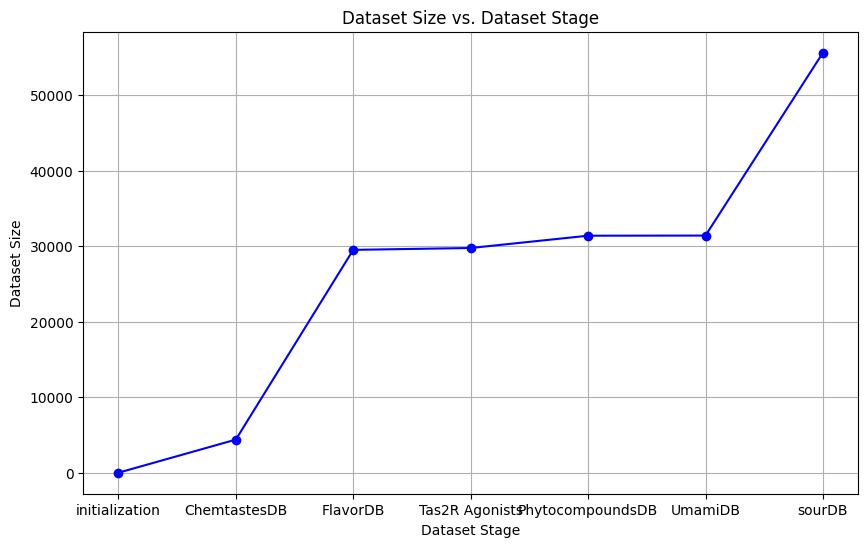

In [369]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))  # Optional: Set the size of the figure

# Plot dataset size vs. dataset stage
plt.plot(dataset_stage, full_dataset_size, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Dataset Stage')
plt.ylabel('Dataset Size')
plt.title('Dataset Size vs. Dataset Stage')
plt.grid(True)  # Optional: Add grid lines for better readability

# Display the plot
plt.show()
